In [3]:
pip install xgboost

'diabetes.csv' already exists. Skipping unzipping.

--- 1. Loading and Preprocessing Data ---
--- 2. Splitting Data into Train and Test Sets ---
--- 3. Scaling Features with StandardScaler ---

--- Training Logistic Regression ---
Accuracy: 0.7078
ROC AUC Score: 0.8130
Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.82      0.78       100
           1       0.60      0.50      0.55        54

    accuracy                           0.71       154
   macro avg       0.68      0.66      0.67       154
weighted avg       0.70      0.71      0.70       154


--- Training Support Vector Machine ---
Accuracy: 0.7403
ROC AUC Score: 0.7964
Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.84      0.81       100
           1       0.65      0.56      0.60        54

    accuracy                           0.74       154
   macro avg       0.71      0.70      0.70       154
weigh

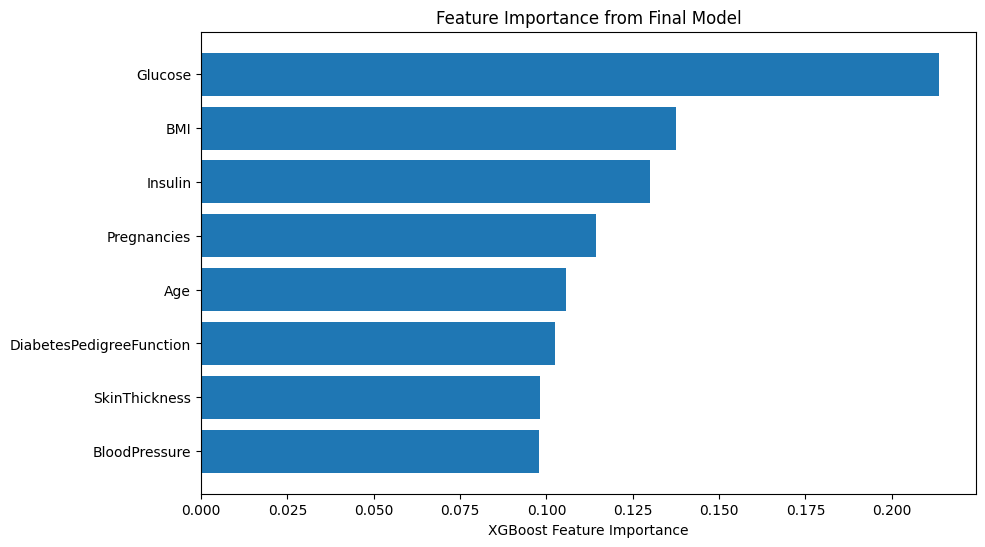


--- 9b. SHAP Analysis ---
Initializing SHAP TreeExplainer...
Calculating SHAP values for the test set...
Generating SHAP Summary Plot...


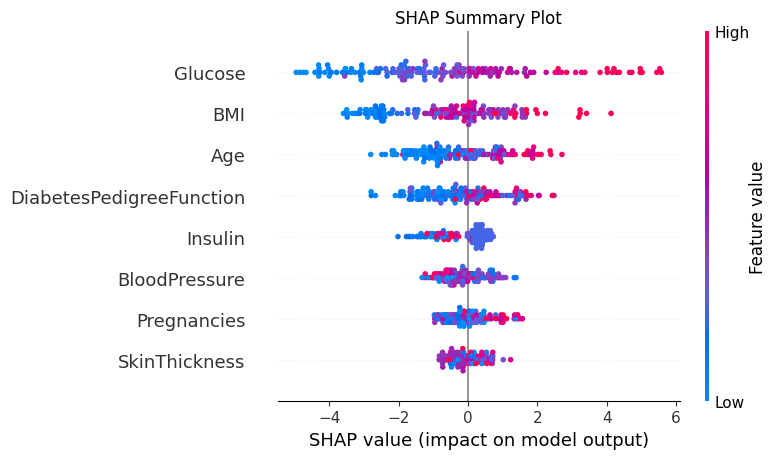


Generating SHAP Force Plot for the first test instance...


<Figure size 640x480 with 0 Axes>

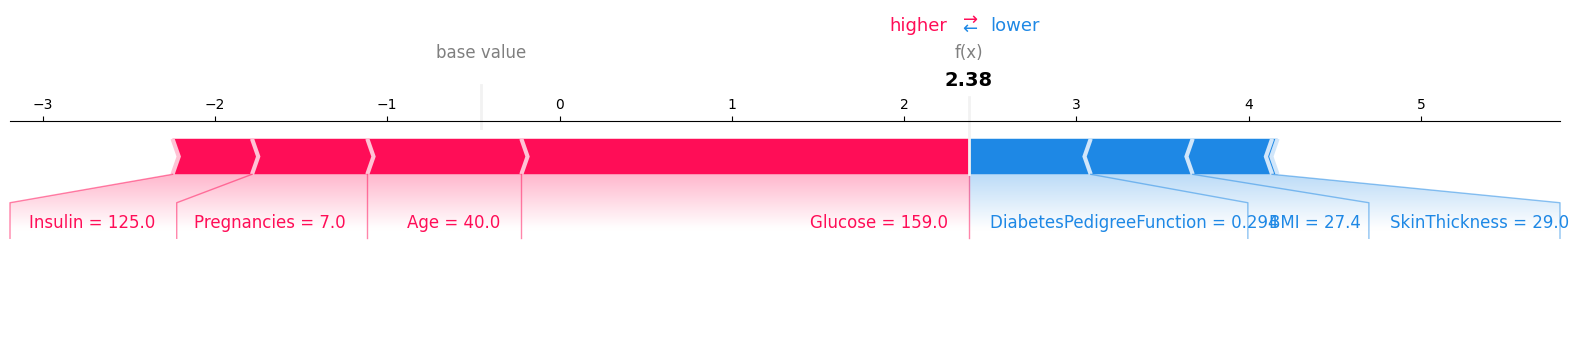


SHAP analysis complete.


In [4]:
import pandas as pd
import numpy as np
import warnings
import os
import zipfile
import sys

# --- Scikit-Learn ---
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score

# --- Gradient Boosting Libraries ---
import lightgbm as lgb
from xgboost import XGBClassifier

# Ignore warnings for cleaner output
warnings.filterwarnings('ignore')

# --- 0. Setup: Unzip Data if Necessary ---
zip_file_path = 'archive.zip'
csv_file_path = 'diabetes.csv'

# Check if the CSV file already exists
if not os.path.exists(csv_file_path):
    print(f"'{csv_file_path}' not found.")
    # If not, check if the ZIP file exists
    if os.path.exists(zip_file_path):
        print(f"Found '{zip_file_path}'. Unzipping...")
        try:
            with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
                zip_ref.extractall('.') # Extract to the current directory
            print(f"Successfully unzipped to '{csv_file_path}'.")
        except Exception as e:
            print(f"Error unzipping file: {e}")
            sys.exit() # Exit if unzipping fails
    else:
        # If neither file exists, exit with an error
        print(f"Error: Neither '{csv_file_path}' nor '{zip_file_path}' found.")
        print("Please download the dataset from Kaggle and place 'archive.zip' in the same directory as this script.")
        sys.exit()
else:
    print(f"'{csv_file_path}' already exists. Skipping unzipping.")


# --- 1. Load and Preprocess Data ---
print("\n--- 1. Loading and Preprocessing Data ---")
try:
    df = pd.read_csv(csv_file_path)
except FileNotFoundError:
    print(f"Critical Error: Could not read '{csv_file_path}' after setup. Please check the file.")
    sys.exit()

# Handle the "missing" zero values by replacing them with the median
cols_to_clean = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']
for col in cols_to_clean:
    df[col] = df[col].replace(0, np.nan)
    median_val = df[col].median()
    df[col] = df[col].fillna(median_val)

# --- 2. Separate Features and Target & Split Data ---
print("--- 2. Splitting Data into Train and Test Sets ---")
X = df.drop('Outcome', axis=1)
y = df['Outcome']

# Split data, stratifying to maintain class distribution
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# --- 3. Scale Features ---
print("--- 3. Scaling Features with StandardScaler ---")
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


# --- 4. Define Models to Train ---
models = {
    'Logistic Regression': LogisticRegression(random_state=42),
    'Support Vector Machine': SVC(probability=True, random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42),
    'LightGBM': lgb.LGBMClassifier(random_state=42),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42) # XGBoost is added here
}

# --- 5. Train and Evaluate Each Model ---
results = []

for name, model in models.items():
    print(f"\n--- Training {name} ---")

    # Train the model
    model.fit(X_train_scaled, y_train)

    # Make predictions
    y_pred = model.predict(X_test_scaled)
    y_pred_proba = model.predict_proba(X_test_scaled)[:, 1]

    # Evaluate metrics
    accuracy = accuracy_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred_proba)

    # Print individual model results
    print(f"Accuracy: {accuracy:.4f}")
    print(f"ROC AUC Score: {roc_auc:.4f}")
    print("Classification Report:")
    print(classification_report(y_test, y_pred))

    # Store results for final summary
    results.append({
        'Model': name,
        'Accuracy': accuracy,
        'ROC AUC': roc_auc
    })

# --- 6. Final Summary ---
print("\n" + "="*50)
print("           FINAL MODEL COMPARISON")
print("="*50)

# Create a DataFrame from the results and sort by ROC AUC
results_df = pd.DataFrame(results).sort_values(by='ROC AUC', ascending=False).reset_index(drop=True)
print(results_df)
print("\n")

# --- (Your existing code from step 1 to 6 goes here) ---

# --- 7. Hyperparameter Tuning for the Best Model (XGBoost) ---
print("\n" + "="*50)
print("     7. HYPERPARAMETER TUNING FOR XGBOOST")
print("="*50)

from sklearn.model_selection import RandomizedSearchCV

# Define the hyperparameter grid to search
# These are some of the most important hyperparameters for XGBoost
param_dist = {
    'n_estimators': [100, 200, 300, 400, 500],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [3, 4, 5, 6, 7],
    'subsample': [0.6, 0.7, 0.8, 0.9, 1.0], # Percentage of samples used per tree
    'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0] # Percentage of features used per tree
}

# We use RandomizedSearchCV because it's more efficient than GridSearchCV
# It samples a fixed number of parameter settings from the specified distributions.
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)

# n_iter: number of parameter settings that are sampled.
# cv: number of folds in cross-validation.
random_search = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=param_dist,
    n_iter=50,  # Try 50 different combinations
    cv=5,
    scoring='roc_auc', # We optimize for ROC AUC
    n_jobs=-1,  # Use all available CPU cores
    random_state=42,
    verbose=1 # Show progress
)

# Fit the random search to the data
print("Running Randomized Search CV...")
random_search.fit(X_train_scaled, y_train)

print(f"\nBest Parameters found: {random_search.best_params_}")
print(f"Best ROC AUC score during search: {random_search.best_score_:.4f}")

# --- 8. Train and Evaluate Final Tuned Model ---
print("\n" + "="*50)
print("     8. FINAL TUNED XGBOOST MODEL EVALUATION")
print("="*50)

# Create the final model with the best parameters
final_xgb_model = XGBClassifier(
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42,
    **random_search.best_params_  # Unpack the best parameters here
)

# Train the final model on the entire training data
final_xgb_model.fit(X_train_scaled, y_train)

# Evaluate on the test set
y_pred_final = final_xgb_model.predict(X_test_scaled)
y_pred_proba_final = final_xgb_model.predict_proba(X_test_scaled)[:, 1]

print("Performance on the Test Set:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_final):.4f}")
print(f"ROC AUC Score: {roc_auc_score(y_test, y_pred_proba_final):.4f}")
print("Classification Report:")
print(classification_report(y_test, y_pred_final))


# --- 9. Model Interpretation ---
print("\n" + "="*50)
print("           9. MODEL INTERPRETATION")
print("="*50)
import matplotlib.pyplot as plt
import shap

# --- 9a. Feature Importance ---
print("\n--- 9a. Feature Importance ---")
# Create a DataFrame for better visualization
feature_importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': final_xgb_model.feature_importances_
}).sort_values(by='Importance', ascending=False)

print(feature_importance_df)

# Plotting feature importance
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.xlabel("XGBoost Feature Importance")
plt.title("Feature Importance from Final Model")
plt.gca().invert_yaxis()
plt.show()


# --- 9b. SHAP Analysis ---
print("\n--- 9b. SHAP Analysis ---")
import shap
import matplotlib.pyplot as plt

# THIS IS THE CRITICAL FIX:
# We MUST use shap.TreeExplainer for tree models like XGBoost.
# The generic shap.Explainer is failing to auto-detect the model type.
print("Initializing SHAP TreeExplainer...")
explainer = shap.TreeExplainer(final_xgb_model)

# Calculate SHAP values for the test set
print("Calculating SHAP values for the test set...")
shap_values = explainer.shap_values(X_test_scaled)

# --- Summary Plot (Beeswarm) ---
print("Generating SHAP Summary Plot...")
plt.title("SHAP Summary Plot")
# The summary_plot uses the calculated SHAP values and the original test data
# (X_test) for clear, interpretable feature values.
shap.summary_plot(shap_values, X_test, feature_names=X.columns)
plt.savefig('shap_summary_plot.png', dpi=300, bbox_inches='tight')


# --- Force Plot for a single prediction ---
print("\nGenerating SHAP Force Plot for the first test instance...")
# The force_plot explains a single prediction.
# It uses the explainer's expected_value (the model's average prediction),
# the SHAP values for the specific instance (shap_values[0,:]),
# and the actual feature values for that instance (X_test.iloc[0,:]).
shap.force_plot(
    explainer.expected_value,
    shap_values[0,:],
    X_test.iloc[0,:],
    feature_names=X.columns,
    matplotlib=True,
    show=True
)

print("\nSHAP analysis complete.")

In [2]:
!pip install --upgrade scikit-learn

In [1]:
pip install --upgrade shap

In [3]:
!pip install xgboost==1.7.6

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.3/200.3 MB 4.0 MB/s eta 0:00:00
  Attempting uninstall: xgboost
    Found existing installation: xgboost 3.1.1
    Uninstalling xgboost-3.1.1:
      Successfully uninstalled xgboost-3.1.1


In [5]:
import joblib
import shap # Make sure to import shap

# --- Create the SHAP Explainer Object ---
# This must be done after your final_xgb_model is trained
print("Creating SHAP explainer...")
explainer = shap.TreeExplainer(final_xgb_model)


# --- Save All Three Objects ---
print("Saving model, scaler, and explainer to disk...")

# 1. Save the trained model
joblib.dump(final_xgb_model, 'diabetes_model.pkl')

# 2. Save the scaler
joblib.dump(scaler, 'scaler.pkl')

# 3. Save the SHAP explainer (This is the new line)
joblib.dump(explainer, 'shap_explainer.pkl')


# Update the confirmation message
print("✅ Model, scaler, and SHAP explainer saved successfully!")

Creating SHAP explainer...
Saving model, scaler, and explainer to disk...
✅ Model, scaler, and SHAP explainer saved successfully!


In [6]:
# Install Streamlit and pyngrok
!pip install -q streamlit pyngrok

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 51.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 70.9 MB/s eta 0:00:00


In [7]:
%%writefile app.py

import streamlit as st
import pandas as pd
import numpy as np
import joblib
import shap
import plotly.graph_objects as go
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler # Required for joblib

# --- PAGE CONFIGURATION ---
st.set_page_config(
    page_title="GDM Risk Assessment",
    page_icon="🤰",
    layout="wide",
    initial_sidebar_state="expanded",
)

# --- LOAD ASSETS ---
try:
    model = joblib.load('diabetes_model.pkl')
    scaler = joblib.load('scaler.pkl')
    explainer = joblib.load('shap_explainer.pkl')
except FileNotFoundError:
    st.error("Error: Model, scaler, or explainer files not found. Please ensure all .pkl files are in the directory.")
    st.stop()

# --- DIETARY RECOMMENDATIONS DATABASE (GDM FOCUSED) ---
food_recommendations = {
    'High Risk': {
        'Description': 'This suggests a high probability of GDM. It is essential to consult your doctor promptly. The following diet focuses on strict blood sugar control, which is crucial for a healthy pregnancy under these conditions.',
        'Indian (Veg)': {
            'Breakfast': ['Vegetable Oats or Dalia (Porridge)', 'Ragi Idli/Dosa with minimal chutney', 'Moong Dal Chilla with vegetables'],
            'Lunch': ['Large Salad with grilled Paneer/Tofu', 'Karela (Bitter Gourd) Sabzi with 1-2 Millet (Bajra/Jowar) Rotis', 'Lentil soup (Dal) without rice'],
            'Dinner': ['Cauliflower Rice with Vegetable Curry', 'Steamed vegetables with a small portion of quinoa', 'Clear vegetable and lentil soup'],
            'Foods to Avoid': ['White Rice, Sugar, Maida (refined flour)', 'Fried Foods, Processed Snacks', 'Sweet Fruits (e.g., Mango, Grapes, Banana)', 'Root Vegetables (e.g., Potato, Sweet Potato)']
        },
        'Indian (Non-Veg)': {
            'Breakfast': ['Egg white omelette with spinach and mushrooms', 'Boiled Eggs (2)'],
            'Lunch': ['Grilled Fish with sautéed vegetables', 'Skinless Chicken curry (thin, soupy gravy) with a large salad', 'Clear chicken and vegetable broth'],
            'Dinner': ['Baked Chicken breast with greens', 'Fish Tikka (baked, not fried)', 'Scrambled eggs with vegetables'],
            'Foods to Avoid': ['Red Meat (Mutton)', 'Fried Fish/Chicken', 'Sugary Drinks & Fruit Juices', 'Full-fat dairy']
        }
    },
    'Moderate Risk': {
        'Description': 'The model indicates a significant risk of GDM. Discussing these results with your healthcare provider is highly recommended. This diet plan focuses on proactive management of blood sugar.',
        'Indian (Veg)': {
            'Breakfast': ['Oats Upma with vegetables', 'Moong Dal Chilla', 'Greek Yogurt with a few berries'],
            'Lunch': ['Quinoa with Mixed Vegetable Curry', 'Brown Rice (small portion) with Dal Tadka and a large Salad', 'Millet Roti with Paneer Bhurji'],
            'Dinner': ['Grilled Tofu with Sautéed Vegetables', 'Lentil Soup (Dal) with a side of steamed greens', 'Besan Kadhi with Brown Rice (small portion)'],
            'Foods to Limit': ['Potatoes and other root vegetables', 'White Bread/Rice (switch to whole grains)', 'Sweets and desserts', 'Sweetened beverages']
        },
        'Indian (Non-Veg)': {
            'Breakfast': ['Scrambled Eggs (whole eggs) with Spinach', 'Oats with small pieces of chicken'],
            'Lunch': ['Grilled Fish with Brown Rice and Sabzi', 'Chicken Curry (less oil) with Millet Roti', 'Egg Bhurji with whole wheat toast'],
            'Dinner': ['Chicken Tikka (baked) with Mint Chutney and Salad', 'Fish Curry with limited brown rice', 'Clear Chicken Soup'],
            'Foods to Limit': ['High-fat gravies', 'Processed meats (sausages, salami)', 'Full-fat dairy products']
        }
    },
    'Low Risk': {
        'Description': 'The model suggests a low likelihood of GDM. This is a great status to maintain. The following suggestions focus on a preventative, healthy pregnancy diet.',
        'Indian (Veg)': {
            'Breakfast': ['Idli/Dosa with Sambhar', 'Poha with vegetables', 'Whole wheat paratha with curd'],
            'Lunch': ['Standard Thali: Roti, Sabzi, Dal, Rice (portion control), Salad', 'Rajma Chawal with a side of raita'],
            'Dinner': ['Paneer Tikka Masala with whole wheat roti', 'Vegetable Pulao with Raita', 'Dal Makhani (homemade, less butter)'],
            'Good Habits': ['Stay hydrated with water', 'Include a variety of colorful vegetables', 'Choose whole fruits over juices']
        },
        'Indian (Non-Veg)': {
            'Breakfast': ['Omelette with whole wheat bread', 'Keema Paratha (limited oil)'],
            'Lunch': ['Chicken Biryani (homemade, less oil) with Raita', 'Fish Fry (pan-fried) with Dal and Rice'],
            'Dinner': ['Butter Chicken (homemade, healthier version) with Naan', 'Mutton Curry (lean cuts, occasional) with Roti'],
            'Good Habits': ['Choose lean cuts of meat', 'Prefer grilling, baking, or stir-frying over deep-frying']
        }
    },
    'Minimal Risk': {
        'Description': 'Excellent! The model indicates a minimal risk of GDM. Your focus should be on continuing a balanced and nutritious diet for a healthy pregnancy.',
        'Indian (Veg)': {
            'General Advice': [
                'Continue eating a balanced diet rich in fiber, vitamins, and minerals.',
                'Ensure you are getting adequate protein from sources like paneer, dal, and legumes.',
                'There are no specific restrictions, but moderation is always key for long-term health and a healthy pregnancy.'
            ]
        },
        'Indian (Non-Veg)': {
            'General Advice': [
                'Your current dietary patterns appear healthy for your pregnancy.',
                'Continue to include lean proteins like chicken, fish, and eggs.',
                'Focus on maintaining a healthy pregnancy weight as advised by your doctor.'
            ]
        }
    }
}

# --- HELPER FUNCTIONS ---
def get_risk_level(probability):
    """Maps a probability score to a risk category and color."""
    prob_percent = probability * 100
    if prob_percent >= 75:
        return 'High Risk', 'red'
    elif 50 <= prob_percent < 75:
        return 'Moderate Risk', 'orange'
    elif 20 <= prob_percent < 50:
        return 'Low Risk', 'gold'
    else:
        return 'Minimal Risk', 'green'

def predict_diabetes(data):
    feature_names = ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age']
    input_df = pd.DataFrame([data], columns=feature_names)
    scaled_input = scaler.transform(input_df)
    prediction = model.predict(scaled_input)
    prediction_proba = model.predict_proba(scaled_input)
    return prediction[0], prediction_proba[0], scaled_input

def st_shap(plot, height=None):
    shap_html = f"<head>{shap.getjs()}</head><body>{plot.html()}</body>"
    st.components.v1.html(shap_html, height=height)

# --- UI LAYOUT ---
st.title('🤰 Gestational Diabetes (GDM) Risk Assessment')
st.markdown("This tool assesses the risk of GDM in expectant mothers and provides tailored dietary guidance.")
st.write('---')

# --- SIDEBAR ---
st.sidebar.header('Patient Medical Data Entry')
pregnancies = st.sidebar.number_input('Number of Pregnancies', min_value=0, max_value=20, value=1, step=1)

#
# --- THIS IS THE CORRECTED LINE ---
#
glucose = st.sidebar.number_input('Glucose Level (mg/dL)', min_value=0, max_value=999, value=120) # max_value changed from 250 to 999
#
# ------------------------------------
#
blood_pressure = st.sidebar.number_input('Blood Pressure (mm Hg)', min_value=0, max_value=140, value=70)
skin_thickness = st.sidebar.number_input('Skin Thickness (mm)', min_value=0, max_value=100, value=20)
insulin = st.sidebar.number_input('Insulin Level (mu U/ml)', min_value=0, max_value=900, value=80)
bmi = st.sidebar.number_input('Body Mass Index (BMI)', min_value=0.0, max_value=70.0, value=25.0, format="%.2f")
diabetes_pedigree = st.sidebar.number_input('Diabetes Pedigree Function', min_value=0.0, max_value=2.5, value=0.5, format="%.3f")
age = st.sidebar.number_input('Age', min_value=21, max_value=90, value=30)
user_data = {
    'Pregnancies': pregnancies, 'Glucose': glucose, 'BloodPressure': blood_pressure,
    'SkinThickness': skin_thickness, 'Insulin': insulin, 'BMI': bmi,
    'DiabetesPedigreeFunction': diabetes_pedigree, 'Age': age
}

# --- PREDICTION AND RESULTS DISPLAY ---
if st.sidebar.button('**Assess Risk & Get Diet Plan**', type="primary"):
    data_for_prediction = user_data.copy()
    cols_to_clean = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']
    medians = {'Glucose': 117, 'BloodPressure': 72, 'SkinThickness': 29, 'Insulin': 125, 'BMI': 32.3}
    for col in cols_to_clean:
        if data_for_prediction[col] == 0:
            data_for_prediction[col] = medians[col]

    prediction, prediction_proba, scaled_input = predict_diabetes(data_for_prediction)
    probability_of_diabetes = float(prediction_proba[1])
    risk_name, risk_color = get_risk_level(probability_of_diabetes)

    st.subheader('1. Risk Assessment Results')
    col1, col2 = st.columns(2)
    with col1:
        st.markdown(f"**Predicted Risk Level:** <span style='color:{risk_color}; font-size: 24px; font-weight: bold;'>{risk_name}</span>", unsafe_allow_html=True)
        st.metric(label="Probability of GDM", value=f"{probability_of_diabetes:.2%}")
        st.info(food_recommendations[risk_name]['Description'])

    with col2:
        fig = go.Figure(go.Indicator(
            mode = "gauge+number", value = probability_of_diabetes * 100,
            domain = {'x': [0, 1], 'y': [0, 1]}, title = {'text': "Risk Score"},
            gauge = {'axis': {'range': [None, 100]}, 'bar': {'color': risk_color},
                     'steps': [{'range': [0, 20], 'color': 'lightgreen'}, {'range': [20, 50], 'color': '#F9E79F'},
                               {'range': [50, 75], 'color': 'orange'}, {'range': [75, 100], 'color': 'lightcoral'}]}))
        fig.update_layout(height=250, margin=dict(l=10, r=10, b=10, t=40))
        st.plotly_chart(fig, use_container_width=True)

    with st.expander("Click here to see the factors influencing this prediction"):
        st.subheader('2. Prediction Explanation')
        shap_values = explainer.shap_values(scaled_input)
        force_plot = shap.force_plot(explainer.expected_value, shap_values[0,:], pd.DataFrame([user_data]), matplotlib=False)
        st_shap(force_plot, 400)
        st.markdown("""*This chart shows which factors pushed the risk score higher (red) or lower (blue). Longer bars have a bigger impact.*""")

    st.write("---")

    st.subheader(f"3. Dietary Guidance for a '{risk_name}' Status")
    st.warning("🚨 **Disclaimer:** This is an educational tool, not medical advice. Please consult your doctor or a registered dietitian for a personalized pregnancy nutrition plan.", icon="⚠️")

    recommendations = food_recommendations[risk_name]
    veg_tab, nonveg_tab = st.tabs(["🍛 Indian (Vegetarian)", "🍗 Indian (Non-Vegetarian)"])

    with veg_tab:
        for meal, items in recommendations['Indian (Veg)'].items():
            if meal not in ['Description', 'General Advice']:
                st.markdown(f"**{meal}**")
                for item in items:
                    st.markdown(f"- {item}")
        if 'General Advice' in recommendations['Indian (Veg)']:
            for item in recommendations['Indian (Veg)']['General Advice']:
                st.markdown(f"• {item}")

    with nonveg_tab:
        for meal, items in recommendations['Indian (Non-Veg)'].items():
            if meal not in ['Description', 'General Advice']:
                st.markdown(f"**{meal}**")
                for item in items:
                    st.markdown(f"- {item}")
        if 'General Advice' in recommendations['Indian (Non-Veg)']:
            for item in recommendations['Indian (Non-Veg)']['General Advice']:
                st.markdown(f"• {item}")

else:
    st.info('Enter the patient\'s data in the sidebar and click the button to assess GDM risk and receive guidance.')

Writing app.py


In [27]:
from pyngrok import ngrok

# --- CORRECTED AUTHENTICATION STEP ---
# The string inside the quotes should ONLY be your token.
NGROK_AUTH_TOKEN = "34pfsI49pWh4M78Ot4tjnNe0q55_4ehQZbAGgsL83t2zYsgoE"
ngrok.set_auth_token(NGROK_AUTH_TOKEN)
# ------------------------------------

# Terminate any existing ngrok tunnels if they exist
ngrok.kill()

# Set up the public URL to your Streamlit app (which runs on port 8501)
public_url = ngrok.connect(8501)
print(f"🚀 Your Streamlit app is live! Click here: {public_url}")

# Run the Streamlit app
!streamlit run app.py --server.headless true

🚀 Your Streamlit app is live! Click here: NgrokTunnel: "https://poppylike-uneducated-jannet.ngrok-free.dev" -> "http://localhost:8501"



  You can now view your Streamlit app in your browser.

  Local URL: http://localhost:8501
  Network URL: http://172.28.0.12:8501
  External URL: http://34.186.29.3:8501

  Stopping...
  Stopping...


In [8]:
# Install Streamlit, pyngrok, and the new libraries
!pip install -q streamlit pyngrok plotly shap

In [1]:
%%writefile requirements.txt
streamlit
pandas
numpy
scikit-learn
xgboost
shap
plotly
joblib

Writing requirements.txt


In [2]:
%%writefile .gitignore
# Ignore Python cache files
__pycache__/
*.py[cod]
*$py.class

# Ignore Colab-specific files
.config/
sample_data/

Writing .gitignore
